In [1]:
#!pip install praw transformers torch
import praw
import pandas as pd
import numpy as np
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
import matplotlib.pyplot as plt
import seaborn as sns
import re
from datetime import datetime, timedelta
from langdetect import detect, LangDetectException


2024-06-13 18:05:37.639288: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
user_agent = "Brand sentiment analysis"
reddit = praw.Reddit(
  client_id="ujQpmAa-rxhI6tgE246E4w",
  client_secret="BnhybdI_fallhH64Us6vutIfsXP21Q",
  user_agent=user_agent
)

### fetch reddit title and body

In [3]:
# def fetch_reddit_posts(subreddit, query, limit=100):
#     subreddit = reddit.subreddit(subreddit)
#     posts = []
#     for post in subreddit.search(query, limit=limit):
#         if post.selftext and len(post.selftext.split()) > 6 and len(post.selftext.split()) <= 512:  # This checks if the body (selftext) is not empty
#           posts.append([post.created_utc, post.title, post.selftext])
#     df = pd.DataFrame(posts, columns=["Date", "Title", "Body"])
#     df['Date'] = pd.to_datetime(df['Date'], unit='s')
#     return df


### fetch reddit comments only 

In [3]:
def fetch_reddit_comments(subreddit, query, limit=100, months=6):
    subreddit = reddit.subreddit(subreddit)
    posts = []
    for post in subreddit.search(query, limit=limit):
        post_date = datetime.utcfromtimestamp(post.created_utc)
        post.comments.replace_more(limit=0)  # Ensure all comments are fetched
        comments = post.comments.list()
        #print(comments)
        if comments:
            for comment in comments:
                if hasattr(comment, 'body') and comment.body.strip():  # Ensure comment body is not empty or just whitespace
                    try:
                        comment_date = datetime.utcfromtimestamp(comment.created_utc)
                        if detect(comment.body) == 'en' and comment_date >= datetime.now() - timedelta(days=months*30):  # Adjust to the specific time frame
                            posts.append([comment_date, post.title, comment.body, post.url])
                            english = True
                    except LangDetectException:  # Handle cases where language detection fails
                        continue

    df = pd.DataFrame(posts, columns=["Date", "Title", "Comment", "Url"])
    df['Date'] = pd.to_datetime(df['Date'], unit='s')
    df['Source'] = 'Reddit'
    if english == True: 
        df['Language'] = 'English'
    return df

In [4]:
# df_chatgpt = fetch_reddit_posts('all', 'ChatGPT', 100)
# df_gemini = fetch_reddit_posts('all', 'Gemini AI', 100)
# df_copilot = fetch_reddit_posts('all', 'Copilot AI', 100)

df_neutrogena = fetch_reddit_comments('all', 'neutrogena', 100)
# df_gemini = fetch_reddit_comments('all', 'Gemini AI', 100)
# df_copilot = fetch_reddit_comments('all', 'Copilot AI', 100)

In [6]:
# def clean_text(text):
#   #text = re.sub(r'[^\x00-\x7F]+', ' ', text)
#   text = re.sub(r'\s+', ' ', text) #Remove Extra Whitespace
#   text = re.sub(r'http\S+', '', text)
#   text = re.sub(r'[^\w\s]', '', text)
#   return text.lower()

# df_neutrogena['Comment'] = df_neutrogena['Comment'].apply(clean_text)
# df_chatgpt['Body'] = df_chatgpt['Body'].apply(clean_text)
# df_gemini['Body'] = df_gemini['Body'].apply(clean_text)
# df_copilot['Body'] = df_copilot['Body'].apply(clean_text)
# df_chatgpt['Title'] = df_chatgpt['Title'].apply(clean_text)
# df_gemini['Title'] = df_gemini['Title'].apply(clean_text)
# df_copilot['Title'] = df_copilot['Title'].apply(clean_text)

In [5]:
df_neutrogena

,Date,Title,Comment,Url,Source,Language
0,2024-01-19 18:50:34,[Misc] Your thoughts on Neutrogena?,"In my skincare routine, I'm unsure whether I ...",https://www.reddit.com/r/SkincareAddiction/com...,Reddit,English
1,2024-01-21 02:30:22,[Misc] Your thoughts on Neutrogena?,Neutrogena now marketing wrinkle cream to chil...,https://www.reddit.com/r/SkincareAddiction/com...,Reddit,English
2,2024-01-31 06:11:00,[Misc] Your thoughts on Neutrogena?,The orange oil free acne cleanser WOULDVE been...,https://www.reddit.com/r/SkincareAddiction/com...,Reddit,English
3,2024-01-12 13:05:43,What are your thoughts on Neutrogena sunscreen ?,Is it necessary to double cleans for this suns...,https://i.redd.it/ultpbnpxf1ya1.jpg,Reddit,English
4,2024-04-06 03:25:24,What are your thoughts on Neutrogena sunscreen ?,How often do you reapply it??,https://i.redd.it/ultpbnpxf1ya1.jpg,Reddit,English
...,...,...,...,...,...,...
929,2024-03-21 05:32:36,"Selling Neutrogena, Biooderma innisfree and plum",Innisfree aloe gel - bought from nykaa during ...,https://www.reddit.com/gallery/1bjz6ta,Reddit,English
930,2024-03-21 05:33:24,"Selling Neutrogena, Biooderma innisfree and plum",Neutrogena Hydra boost 50g - from kult as a fr...,https://www.reddit.com/gallery/1bjz6ta,Reddit,English
931,2024-03-21 05:34:42,"Selling Neutrogena, Biooderma innisfree and plum",Plum vanilla scrub 200ml - from plum website ...,https://www.reddit.com/gallery/1bjz6ta,Reddit,English
932,2024-03-21 05:33:52,"Selling Neutrogena, Biooderma innisfree and plum",Bioderma cleansing oil 200ml [SOLD]\n\n\nCondi...,https://www.reddit.com/gallery/1bjz6ta,Reddit,English


In [6]:
df_neutrogena.to_csv('neutrogena.csv', sep=',', index=False, encoding='utf-8')

In [9]:
import os
import pandas as pd

# Define the path to your CSV file
csv_file_path = os.path.join('./neutrogena.csv')

# Check if the file exists
if os.path.exists(csv_file_path):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(csv_file_path)
    # Display the DataFrame
    print(df.head())
else:
    print(f"The file at {csv_file_path} does not exist.")


                  Date                                             Title  \
0  2024-01-19 18:50:34               [Misc] Your thoughts on Neutrogena?   
1  2024-01-21 02:30:22               [Misc] Your thoughts on Neutrogena?   
2  2024-01-31 06:11:00               [Misc] Your thoughts on Neutrogena?   
3  2024-01-12 13:05:43  What are your thoughts on Neutrogena sunscreen ?   
4  2024-04-06 03:25:24  What are your thoughts on Neutrogena sunscreen ?   

                                             Comment  \
0   In my skincare routine, I'm unsure whether I ...   
1  Neutrogena now marketing wrinkle cream to chil...   
2  The orange oil free acne cleanser WOULDVE been...   
3  Is it necessary to double cleans for this suns...   
4                      How often do you reapply it??   

                                                 Url  Source Language  
0  https://www.reddit.com/r/SkincareAddiction/com...  Reddit  English  
1  https://www.reddit.com/r/SkincareAddiction/com...  Reddit  

In [26]:
# Load sentiment analysis pipeline
#model_name = "distilbert-base-uncased-finetuned-sst-2-english" #only pos and neg
model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(model_name)
sentiment_pipeline = pipeline("sentiment-analysis", model=model_name)

def truncate_text(text, max_tokens=510):
    tokens = tokenizer.tokenize(text)
    if len(tokens) > max_tokens:
        tokens = tokens[:max_tokens]
    return tokenizer.convert_tokens_to_string(tokens)

def get_sentiment_score(text):
    truncated_text = truncate_text(text)
    result = sentiment_pipeline(truncated_text)[0]
    return result['label'], result['score']

# # Apply sentiment analysis to both Title and Body
# def apply_sentiment_analysis(df):
#     df['Title_Sentiment'], df['Title_Sentiment_Score'] = zip(*df['Title'].apply(get_sentiment_score))
#     df['Body_Sentiment'], df['Body_Sentiment_Score'] = zip(*df['Body'].apply(get_sentiment_score))
#     return df

# Apply sentiment analysis
df_neutrogena['Sentiment'], df_neutrogena['Sentiment_Score'] = zip(*df_neutrogena['Comment'].apply(get_sentiment_score))
# df_chatgpt['Sentiment'], df_chatgpt['Sentiment_Score'] = zip(*df_chatgpt['Body'].apply(get_sentiment_score))
# df_gemini['Sentiment'], df_gemini['Sentiment_Score'] = zip(*df_gemini['Body'].apply(get_sentiment_score))
# df_copilot['Sentiment'], df_copilot['Sentiment_Score'] = zip(*df_copilot['Body'].apply(get_sentiment_score))

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [27]:
df_neutrogena
df_neutrogena.to_csv('neutrogena', sep=',', index=False, encoding='utf-8')

In [ ]:
# # Combine title and body and apply sentiment analysis
# def apply_combined_sentiment_analysis(df):
#     df['Combined_Text'] = df['Title'] + " " + df['Body']
#     df['Combined_Sentiment'], df['Combined_Sentiment_Score'] = zip(*df['Combined_Text'].apply(get_sentiment_score))
#     return df

# # Example DataFrames
# # Assuming df_chatgpt, df_gemini, df_copilot are already defined and have 'Title' and 'Body' columns
# df_chatgpt = apply_combined_sentiment_analysis(df_chatgpt)
# df_gemini = apply_combined_sentiment_analysis(df_gemini)
# df_copilot = apply_combined_sentiment_analysis(df_copilot)

In [28]:
# Display sentiment statistics
print("Neutrogena Sentiment Statistics:")
print(df_neutrogena['Sentiment'].value_counts(normalize=True))

# print("Gemini AI Sentiment Statistics:")
# print(df_gemini['Sentiment'].value_counts(normalize=True))

# print("Copilot AI Sentiment Statistics:")
# print(df_copilot['Sentiment'].value_counts(normalize=True))


Neutrogena Sentiment Statistics:
Sentiment
neutral     0.433161
negative    0.286010
positive    0.280829
Name: proportion, dtype: float64


In [29]:
df_neutrogena

,Date,Title,Comment,Url,Source,Language,Sentiment,Sentiment_Score
0,2024-01-19 18:50:34,[Misc] Your thoughts on Neutrogena?,"In my skincare routine, I'm unsure whether I ...",https://www.reddit.com/r/SkincareAddiction/com...,Reddit,English,neutral,0.909842
1,2024-01-21 02:30:22,[Misc] Your thoughts on Neutrogena?,Neutrogena now marketing wrinkle cream to chil...,https://www.reddit.com/r/SkincareAddiction/com...,Reddit,English,neutral,0.704988
2,2024-01-31 06:11:00,[Misc] Your thoughts on Neutrogena?,The orange oil free acne cleanser WOULDVE been...,https://www.reddit.com/r/SkincareAddiction/com...,Reddit,English,positive,0.718628
3,2024-01-12 13:05:43,What are your thoughts on Neutrogena sunscreen ?,Is it necessary to double cleans for this suns...,https://i.redd.it/ultpbnpxf1ya1.jpg,Reddit,English,neutral,0.899456
4,2024-04-06 03:25:24,What are your thoughts on Neutrogena sunscreen ?,How often do you reapply it??,https://i.redd.it/ultpbnpxf1ya1.jpg,Reddit,English,neutral,0.952640
...,...,...,...,...,...,...,...,...
960,2024-02-24 22:26:33,Found a new Neutrogena tinted sunscreen I real...,would a normal mineral SPF work OK for you the...,https://i.redd.it/wf6tuyfyhhgc1.jpeg,Reddit,English,neutral,0.769681
961,2024-06-03 04:04:10,Found a new Neutrogena tinted sunscreen I real...,"That’s amazing, thank you so much!! I’m lookin...",https://i.redd.it/wf6tuyfyhhgc1.jpeg,Reddit,English,positive,0.920163
962,2024-06-03 04:04:20,Found a new Neutrogena tinted sunscreen I real...,Any other recommendations?,https://i.redd.it/wf6tuyfyhhgc1.jpeg,Reddit,English,neutral,0.876697
963,2024-06-03 04:06:42,Found a new Neutrogena tinted sunscreen I real...,"Not for mineral its been pretty hard, non tint...",https://i.redd.it/wf6tuyfyhhgc1.jpeg,Reddit,English,negative,0.691517


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


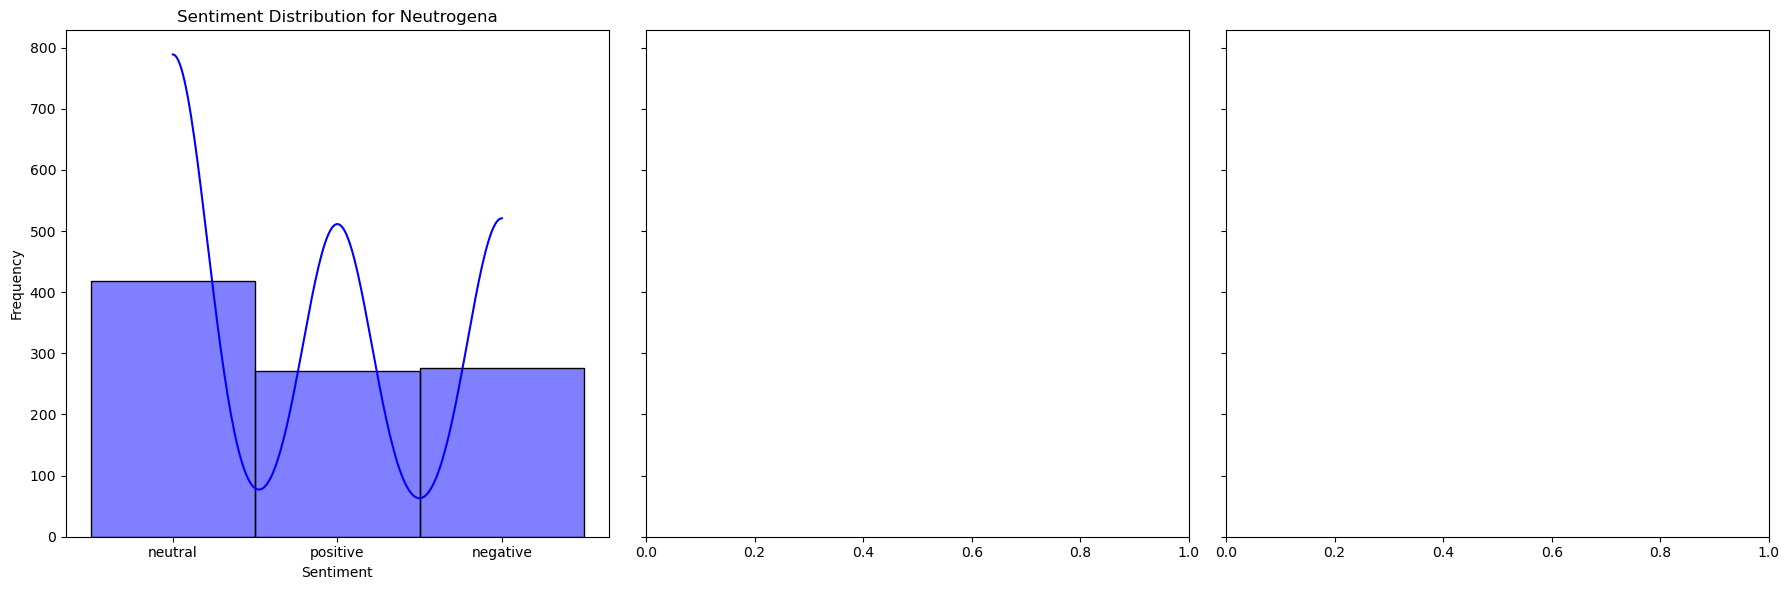

In [30]:
# Plot sentiment distribution for ChatGPT
# Create a figure with 3 subplots side by side
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Plot sentiment distribution for ChatGPT
sns.histplot(df_neutrogena['Sentiment'], kde=True, color='blue', ax=axes[0])
axes[0].set_title('Sentiment Distribution for Neutrogena')
axes[0].set_xlabel('Sentiment')
axes[0].set_ylabel('Frequency')

# # Plot sentiment distribution for Gemini
# sns.histplot(df_gemini['Sentiment'], kde=True, color='red', ax=axes[1])
# axes[1].set_title('Sentiment Distribution for Gemini')
# axes[1].set_xlabel('Sentiment')
# axes[1].set_ylabel('Frequency')

# # Plot sentiment distribution for Copilot
# sns.histplot(df_copilot['Sentiment'], kde=True, color='green', ax=axes[2])
# axes[2].set_title('Sentiment Distribution for Copilot')
# axes[2].set_xlabel('Sentiment')
# axes[2].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()

# other hugging face model

In [17]:
# Load sentiment analysis pipeline
model_name = "j-hartmann/emotion-english-distilroberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
sentiment_pipeline = pipeline("sentiment-analysis", model=model_name)

def truncate_text(text, max_tokens=510):
    tokens = tokenizer.tokenize(text)
    if len(tokens) > max_tokens:
        tokens = tokens[:max_tokens]
    return tokenizer.convert_tokens_to_string(tokens)

def get_sentiment_score(text):
    truncated_text = truncate_text(text)
    result = sentiment_pipeline(truncated_text)[0]
    return result['label'], result['score']

# Apply sentiment analysis
df_neutrogena['Sentiment'], df_neutrogena['Sentiment_Score'] = zip(*df_neutrogena['Comment'].apply(get_sentiment_score))
# df_chatgpt['Sentiment'], df_chatgpt['Sentiment_Score'] = zip(*df_chatgpt['Body'].apply(get_sentiment_score))
# df_gemini['Sentiment'], df_gemini['Sentiment_Score'] = zip(*df_gemini['Body'].apply(get_sentiment_score))
# df_copilot['Sentiment'], df_copilot['Sentiment_Score'] = zip(*df_copilot['Body'].apply(get_sentiment_score))

Token indices sequence length is longer than the specified maximum sequence length for this model (565 > 512). Running this sequence through the model will result in indexing errors


In [18]:
# Display sentiment statistics
print("Neutrogena Sentiment Statistics:")
print(df_neutrogena['Sentiment'].value_counts(normalize=True))
# # Display sentiment statistics
# print("ChatGPT Sentiment Statistics:")
# print(df_chatgpt['Sentiment'].value_counts(normalize=True))

# print("Gemini AI Sentiment Statistics:")
# print(df_gemini['Sentiment'].value_counts(normalize=True))

# print("Copilot AI Sentiment Statistics:")
# print(df_copilot['Sentiment'].value_counts(normalize=True))

Neutrogena Sentiment Statistics:
Sentiment
neutral     0.557513
surprise    0.110881
joy         0.101554
sadness     0.083938
disgust     0.080829
anger       0.044560
fear        0.020725
Name: proportion, dtype: float64


In [19]:
df_neutrogena

,Date,Title,Comment,Url,Source,Language,Sentiment,Sentiment_Score
0,2024-01-19 18:50:34,[Misc] Your thoughts on Neutrogena?,"In my skincare routine, I'm unsure whether I ...",https://www.reddit.com/r/SkincareAddiction/com...,Reddit,English,fear,0.594172
1,2024-01-21 02:30:22,[Misc] Your thoughts on Neutrogena?,Neutrogena now marketing wrinkle cream to chil...,https://www.reddit.com/r/SkincareAddiction/com...,Reddit,English,neutral,0.731859
2,2024-01-31 06:11:00,[Misc] Your thoughts on Neutrogena?,The orange oil free acne cleanser WOULDVE been...,https://www.reddit.com/r/SkincareAddiction/com...,Reddit,English,neutral,0.730524
3,2024-01-12 13:05:43,What are your thoughts on Neutrogena sunscreen ?,Is it necessary to double cleans for this suns...,https://i.redd.it/ultpbnpxf1ya1.jpg,Reddit,English,neutral,0.889980
4,2024-04-06 03:25:24,What are your thoughts on Neutrogena sunscreen ?,How often do you reapply it??,https://i.redd.it/ultpbnpxf1ya1.jpg,Reddit,English,neutral,0.673232
...,...,...,...,...,...,...,...,...
960,2024-02-24 22:26:33,Found a new Neutrogena tinted sunscreen I real...,would a normal mineral SPF work OK for you the...,https://i.redd.it/wf6tuyfyhhgc1.jpeg,Reddit,English,neutral,0.882112
961,2024-06-03 04:04:10,Found a new Neutrogena tinted sunscreen I real...,"That’s amazing, thank you so much!! I’m lookin...",https://i.redd.it/wf6tuyfyhhgc1.jpeg,Reddit,English,surprise,0.478694
962,2024-06-03 04:04:20,Found a new Neutrogena tinted sunscreen I real...,Any other recommendations?,https://i.redd.it/wf6tuyfyhhgc1.jpeg,Reddit,English,neutral,0.876026
963,2024-06-03 04:06:42,Found a new Neutrogena tinted sunscreen I real...,"Not for mineral its been pretty hard, non tint...",https://i.redd.it/wf6tuyfyhhgc1.jpeg,Reddit,English,sadness,0.726998


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


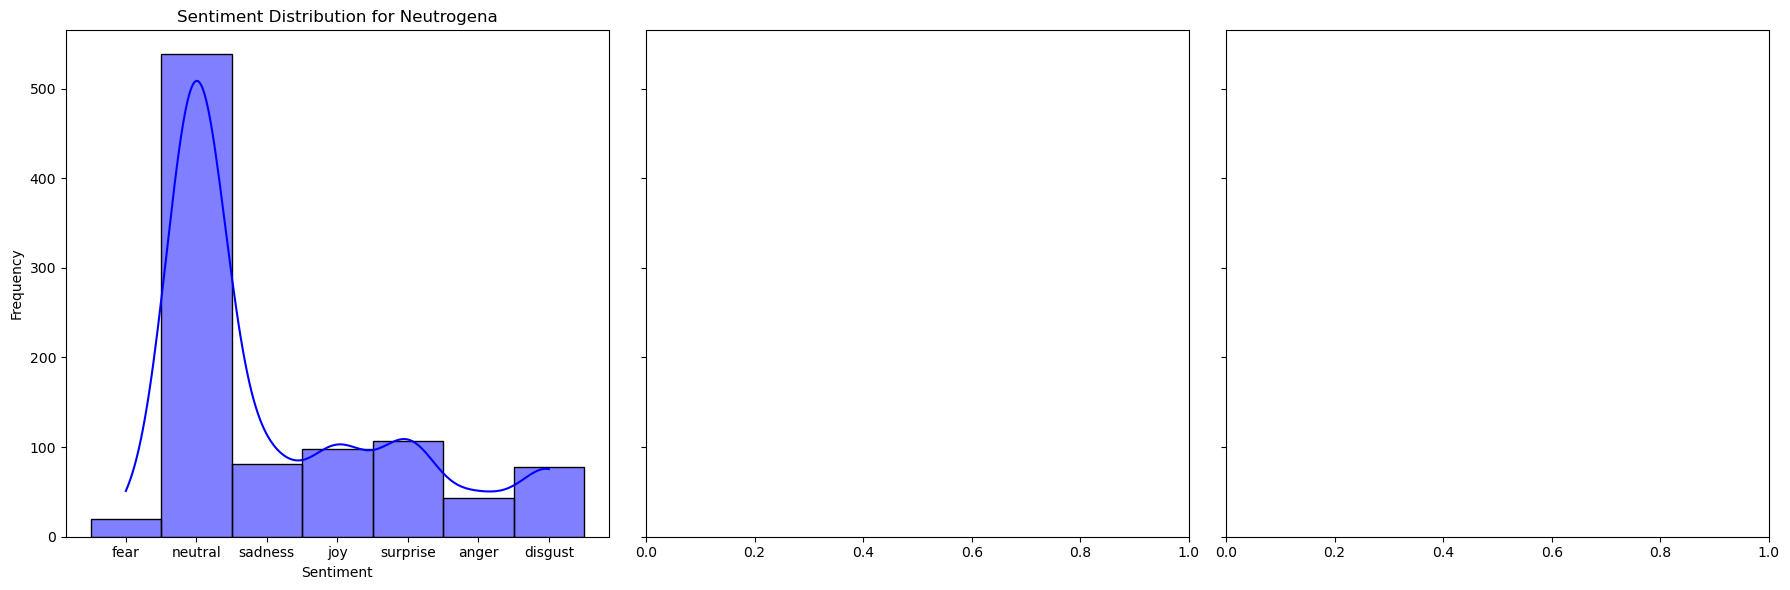

In [25]:

# Prepare the data
neutrogena_sentiment = df_neutrogena['Sentiment'].value_counts(normalize=True)
# chatgpt_sentiment = df_chatgpt['Sentiment'].value_counts(normalize=True)
# gemini_sentiment = df_gemini['Sentiment'].value_counts(normalize=True)
# copilot_sentiment = df_copilot['Sentiment'].value_counts(normalize=True)

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Plot sentiment distribution for ChatGPT
sns.histplot(df_neutrogena['Sentiment'], kde=True, color='blue', ax=axes[0])
axes[0].set_title('Sentiment Distribution for Neutrogena')
axes[0].set_xlabel('Sentiment')
axes[0].set_ylabel('Frequency')

# # Plot for Gemini
# axes[1].bar(gemini_sentiment.index, gemini_sentiment.values, color='green')
# axes[1].set_title('Gemini AI Sentiment Statistics')
# axes[1].set_xlabel('Sentiment')
# axes[1].set_ylabel('Proportion')

# # Plot for Copilot
# axes[2].bar(copilot_sentiment.index, copilot_sentiment.values, color='red')
# axes[2].set_title('Copilot AI Sentiment Statistics')
# axes[2].set_xlabel('Sentiment')
# axes[2].set_ylabel('Proportion')

plt.tight_layout()
plt.show()
